<h1><center><font size="6">RSNA Pneumonia Detection EDA</font></center></h1>

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/10338/logos/thumb76_76.png"></img>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
    -<a href='#21'>Load packages</a>  
     -<a href='#21'>Load the data</a>  
- <a href='#3'>Data exploration</a>   
    -<a href='#31'>Missing data</a>  
    -<a href='#32'>Merge train and class info data</a>  
    -<a href='#33'>Explore DICOM data</a>  
    -<a href='#34'>Add meta information from DICOM data</a>  
    -<a href='#35'>Modality</a>  
    -<a href='#36'>Body Part Examined</a>  
    -<a href='#37'>View Position</a>  
    -<a href='#38'>Conversion Type</a>  
    -<a href='#39'>Rows and Columns</a>  
    -<a href='#310'>Patient Age</a>  
    -<a href='#311'>Patient Sex</a>  
- <a href='#4'>Conclusions</a>    
- <a href='#5'>References</a>    


# <a id="1">Introduction</a>  

This Kernel objective is to explore the dataset for RSNA Pneumonia Detection Challenge.   



# <a id="2">Prepare the data analysis</a>  

## <a id="21">Load packages</a>


In [3]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os
if(IS_LOCAL):
    PATH="./data/input/rsna-pneumonia-detection-challenge"
else:
    PATH="./data/input/"
print(os.listdir(PATH))

['43f620a0-745b-47d4-af1d-02661f920f82.dcm', 'stage_1_test_images', 'stage_1_train_images']


<a href="#0"><font size="1">Go to top</font></a>


## <a id="22">Load the data</a>

Let's load the tabular data. There are two files:
* Detailed class info;  
* Train labels.

In [7]:
class_info_df = pd.read_csv(PATH+'/stage_1_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_1_train_labels.csv')                         

In [8]:
print("Detailed class info -  rows:",class_info_df.shape[0]," columns:", class_info_df.shape[1])
print("Train labels -  rows:",train_labels_df.shape[0]," columns:", train_labels_df.shape[1])

Detailed class info -  rows: 28989  columns: 2
Train labels -  rows: 28989  columns: 6


Let's explore the two loaded files. We will take out a 5 rows samples from each dataset.

In [9]:
class_info_df.sample(5)

patientId                         class
18725  aff6b77a-a1ee-485a-a758-377dbc08f868                        Normal
2654   3352dd2e-717c-4a5a-ad4b-81315818b351                  Lung Opacity
25477  e43f52c1-f08f-43dd-a315-7e52646bd424  No Lung Opacity / Not Normal
21     00f87de5-5fe0-4921-93ea-914d7e683266                        Normal
26223  ea3d1dcb-9222-4e66-b7e6-a45e78bd339e                  Lung Opacity

In [10]:
train_labels_df.sample(5)

patientId      x      y  width  height  \
1613   1780225b-dcb2-4f59-ab9b-d85c91a4ace8    NaN    NaN    NaN     NaN   
25616  e54f1e19-3d46-4d53-8575-2a7863fe0240    NaN    NaN    NaN     NaN   
16380  9e9f1dfe-7412-4fef-9f6d-f344e157815c    NaN    NaN    NaN     NaN   
24465  dbc8473e-fc37-4b23-9051-c1a0a1baf5a3  576.0  477.0  273.0   273.0   
11292  75b12cf7-f556-48e2-9cf8-8ff8f1531f31    NaN    NaN    NaN     NaN   

       Target  
1613        0  
25616       0  
16380       0  
24465       1  
11292       0

In **class detailed info** dataset are given the detailed information about the type of positive or negative class associated with a certain patient.  

In **train labels** dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

<a href="#0"><font size="1">Go to top</font></a>

# <a id="1">Data exploration</a>  

Let's explore the data further.

## <a id="31">Missing data</a>

Let's check missing information in the two datasets.

In [11]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train_labels_df)

Total    Percent
height     20025  69.077926
width      20025  69.077926
y          20025  69.077926
x          20025  69.077926
Target         0   0.000000
patientId      0   0.000000

In [12]:
missing_data(class_info_df)

Total  Percent
class          0      0.0
patientId      0      0.0

The percent missing for x,y, height and width in train labels represents the percent of the target **0** (not **Lung opacity**).

Let's check the class distribution from class detailed info.

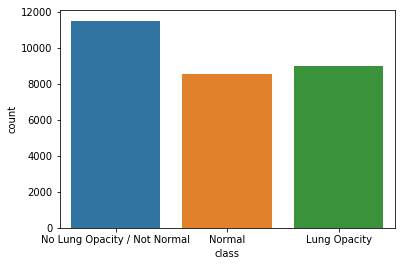

In [13]:
sns.countplot(class_info_df['class'])
plt.show()

Let's look into more details to the classes.

In [14]:

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data['class'].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(class_info_df)

No Lung Opacity / Not Normal  :   11500 or 39.6702197385215%
Lung Opacity                  :   8964 or 30.92207389009624%
Normal                        :   8525 or 29.407706371382247%


**No Lung Opacity / Not Normal** and **Normal** have together the same percent (**69.077%**) as the percent of missing values for target window in class details information.   

In the train set, the percent of data with value for **Target = 1** is therefore **30.92%**.   


<a href="#0"><font size="1">Go to top</font></a>

## <a id="32">Merge train and class detail info data</a>   

Let's merge now the two datasets, using Patient ID as the merge criteria.

In [15]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [16]:
train_class_df.sample(5)

patientId      x      y  width  height  \
35180  fb1a132a-f87e-4d4b-816c-31eb4b4e28c6    NaN    NaN    NaN     NaN   
35053  fa2e48d0-4326-48e9-bb10-9ee2d6600f9e  637.0  229.0  162.0   429.0   
22675  acea0494-388b-4745-a430-892751494e8c  259.0  409.0  170.0   384.0   
33082  ecca50bd-8b93-4abd-82c4-76db7bc980dc    NaN    NaN    NaN     NaN   
8282   4c445a68-b7af-455c-b8f0-a94a4cc6eb13    NaN    NaN    NaN     NaN   

       Target                         class  
35180       0  No Lung Opacity / Not Normal  
35053       1                  Lung Opacity  
22675       1                  Lung Opacity  
33082       0                        Normal  
8282        0  No Lung Opacity / Not Normal

### Target and class  

Let's plot the number of examinations for each class detected, grouped by Target value.

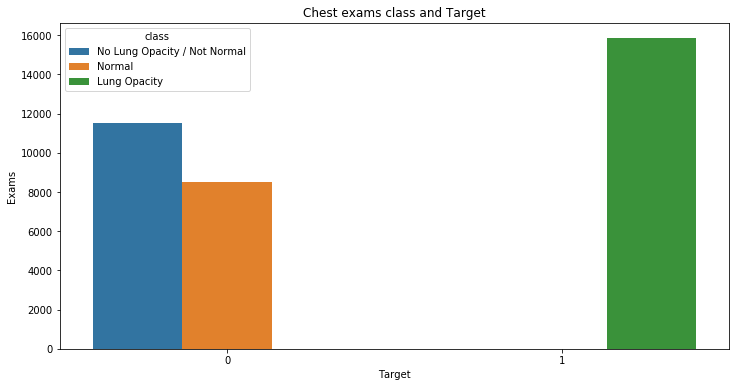

In [17]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df)
plt.title("Chest exams class and Target")
plt.show()

All chest examinations with`Target` = **1** (pathology detected) associated with `class`:  **Lung Opacity**.    

The chest examinations with `Target` = **0** (no pathology detected) are either of `class`: **Normal** or `class`: **No Lung Opacity / Not Normal**.

### Detected Lung Opacity window   

For the class **Lung Opacity**, corresponding to values of **Target = 1**, we plot the density of **x**, **y**, **width** and **height**.



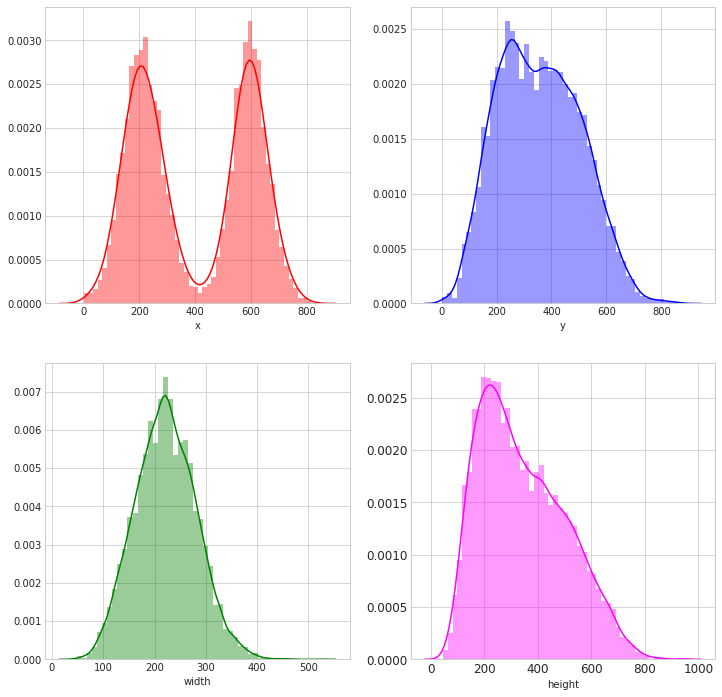

In [18]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can plot also the center of the rectangles points in the plane x0y.   The centers of the rectangles are the points $$x_c = x + width/2$$ and $$y_c = y + height / 2$$.

We will show a sample of center points superposed with the corresponding sample of the rectangles.
The rectangles are created using the method described in Kevin's Kernel <a href="#4">[1]</a>.

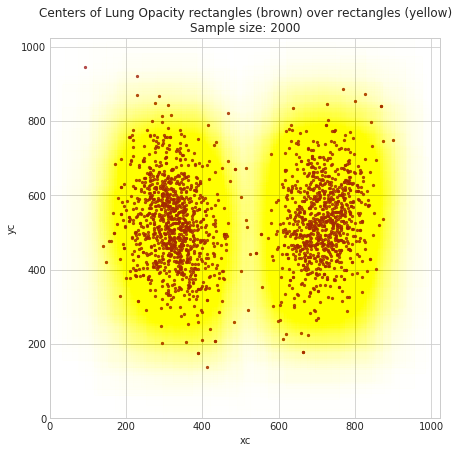

In [19]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()



Let's read now the DICOM data in the train set.

<a href="#0"><font size="1">Go to top</font></a>

## <a id="33">Explore DICOM data</a>  

Let's read now the DICOM data in the train set.

In [20]:
image_sample_path = os.listdir(PATH+'/stage_1_train_images')[:5]
print(image_sample_path)

['43f620a0-745b-47d4-af1d-02661f920f82.dcm', 'd04cbe24-c089-4ef8-b0f0-f6eb21f61c4c.dcm', 'ca5db9d8-52a0-4cfc-9b3e-b8f75cef0e27.dcm', 'e07110c1-7afa-45b3-8de5-901f0a96e394.dcm', '3fdef5f1-8ae2-4f9a-a72f-b094e3b47d37.dcm']


The names of the files are the patients IDs.    
Let's check how many images are in the train and test folders.

In [21]:
image_train_path = os.listdir(PATH+'/stage_1_train_images')
image_test_path = os.listdir(PATH+'/stage_1_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 25684 
Number of images in test set: 1000




Only a reduced number of images are present in the training set (**25684**), compared with the number of  images in the train_df data (**28989**).  

It might be that we do have duplicated entries in the train and class datasets. Let's check this.

### Check duplicates in train dataset


In [22]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())      

Unique patientId in  train_class_df:  25684


We confirmed that the number of unique patientsId are equal with the number of DICOM images in the train set.  

Let's see what entries are duplicated. We want to check how are these distributed accross classes and Target value.

In [23]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11500
1      1       0                        Normal     8525
2      1       1                  Lung Opacity     2481
3      4       1                  Lung Opacity     3062
4      9       1                  Lung Opacity      105
5     16       1                  Lung Opacity       11

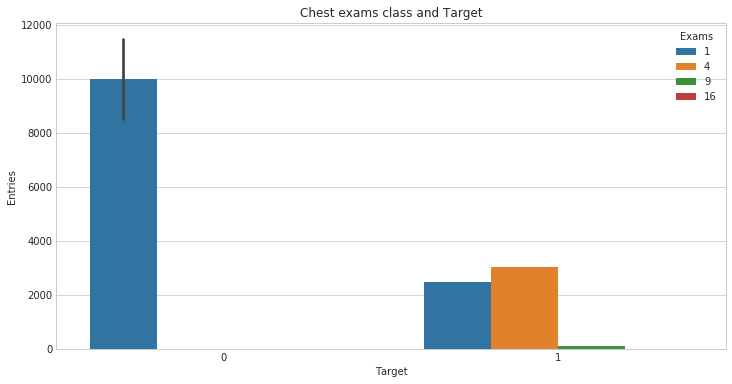

In [24]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Exams',data=df2)
plt.title("Chest exams class and Target")
plt.show()


Let's now extract one image and process the DICOM information. 

### DICOM meta data

In [25]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_1_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

We can observe that we do have available some useful information in the DICOM metadata with predictive value, for example:   
* Patient sex;   
* Patient age;  
* Modality;  
* Body part examined;  
* View position;  
* Rows & Columns;  
* Pixel Spacing.  


Let's sample few images having the **Target = 1**.

### Plot DICOM images with Target = 1

In [26]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_1_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

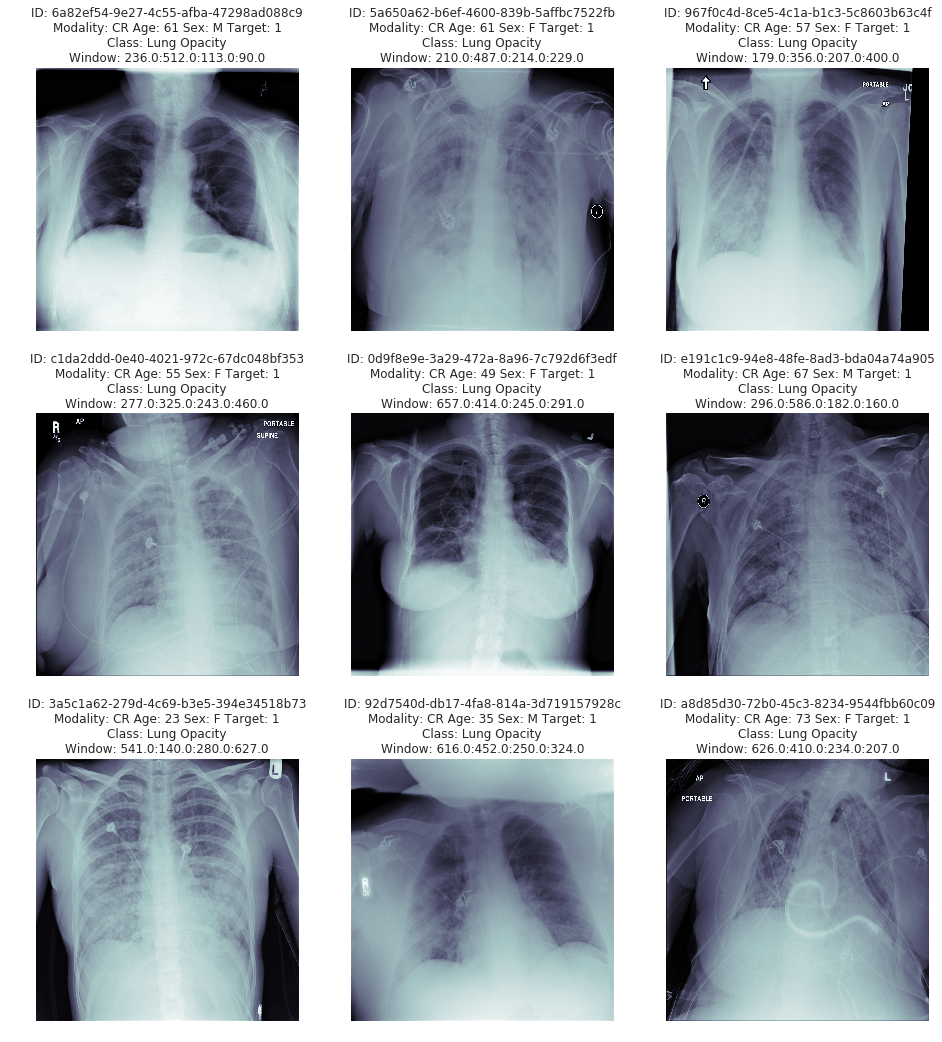

In [27]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with **Target = 1** and gather all coordinates of the windows showing a **Lung Opacity** on the same image.  The simples method is show in <a href='#5'>[1]</a> and we will adapt our rendering from this method.

In [28]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_1_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

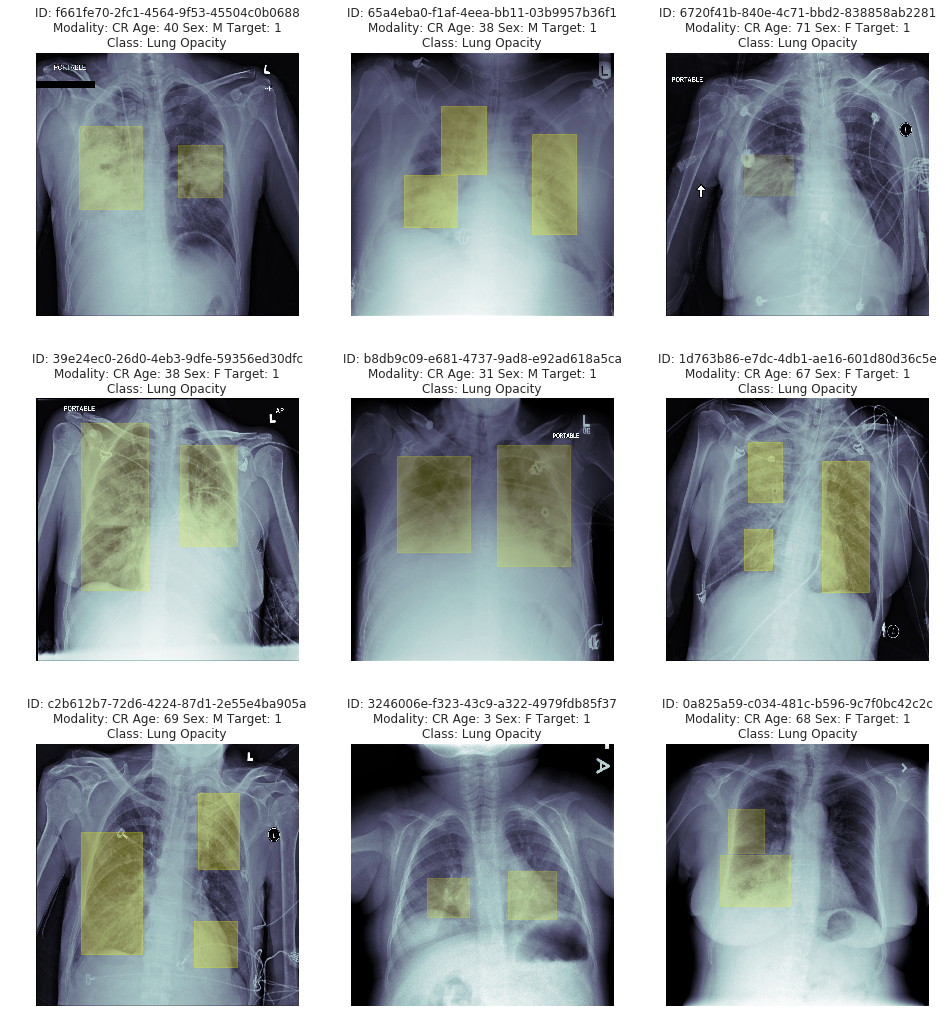

In [29]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

For some of the images with **Target=1**, we might see multiple areas (boxes/rectangles) with **Lung Opacity**.

Let's sample few images having the **Target = 0**.   

### Plot DICOM images with Target = 0


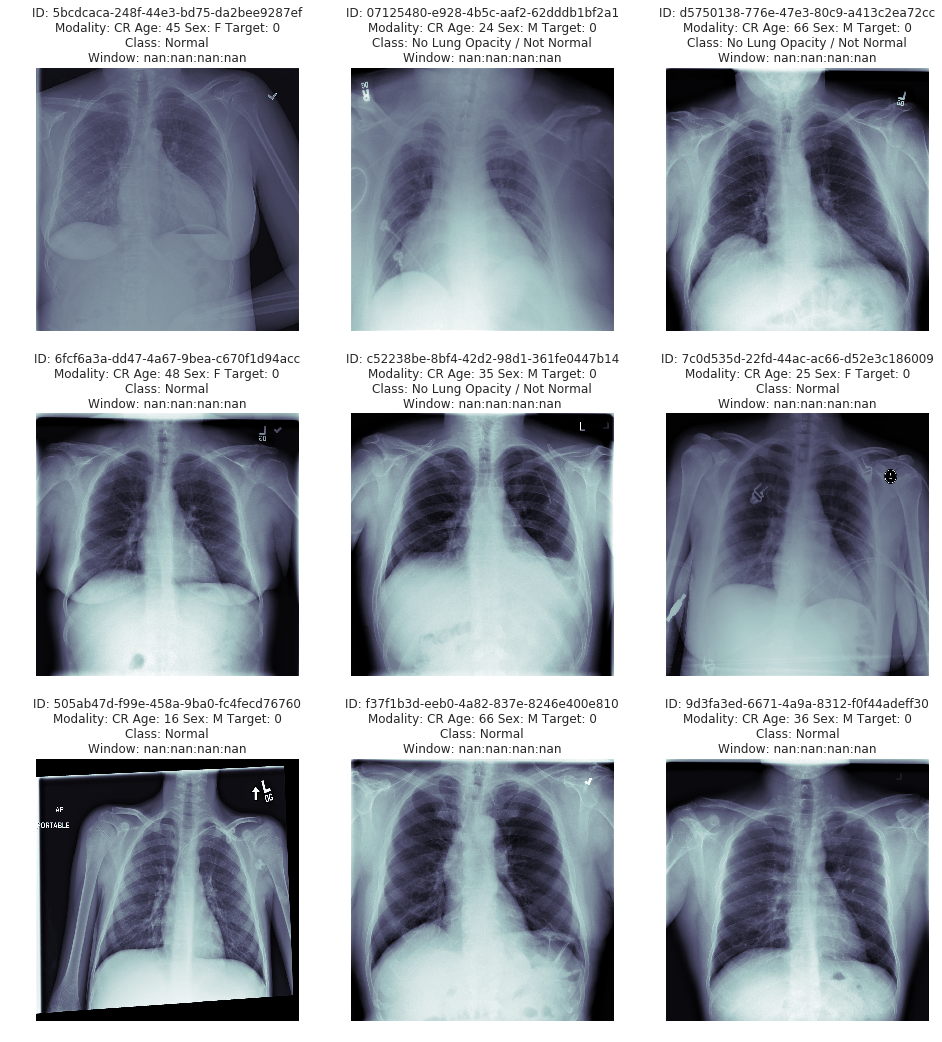

In [30]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

## Density histogram analysis

In [31]:
def show_dicom_hist(data):
    img_data = list(data.T.to_dict().values())
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_1_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        if i == 0:
            data_row_sum = dcm.dcmread(imagePath).pixel_array
        else: 
            data_row_sum += dcm.dcmread(imagePath).pixel_array
            
    plt.hist(data_row_sum.flatten(), bins='auto', normed=True) 
    plt.show()

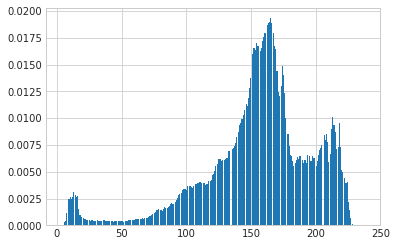

In [32]:
show_dicom_hist(train_class_df[train_class_df['Target']==1].sample(1))

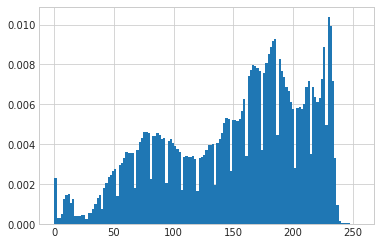

In [33]:
show_dicom_hist(train_class_df[train_class_df['Target']==0].sample(1))

## Gradient analysis

In [34]:
def show_dicom_gradient_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_1_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(np.gradient(np.gradient(data_row_img.pixel_array)[1])[1], cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

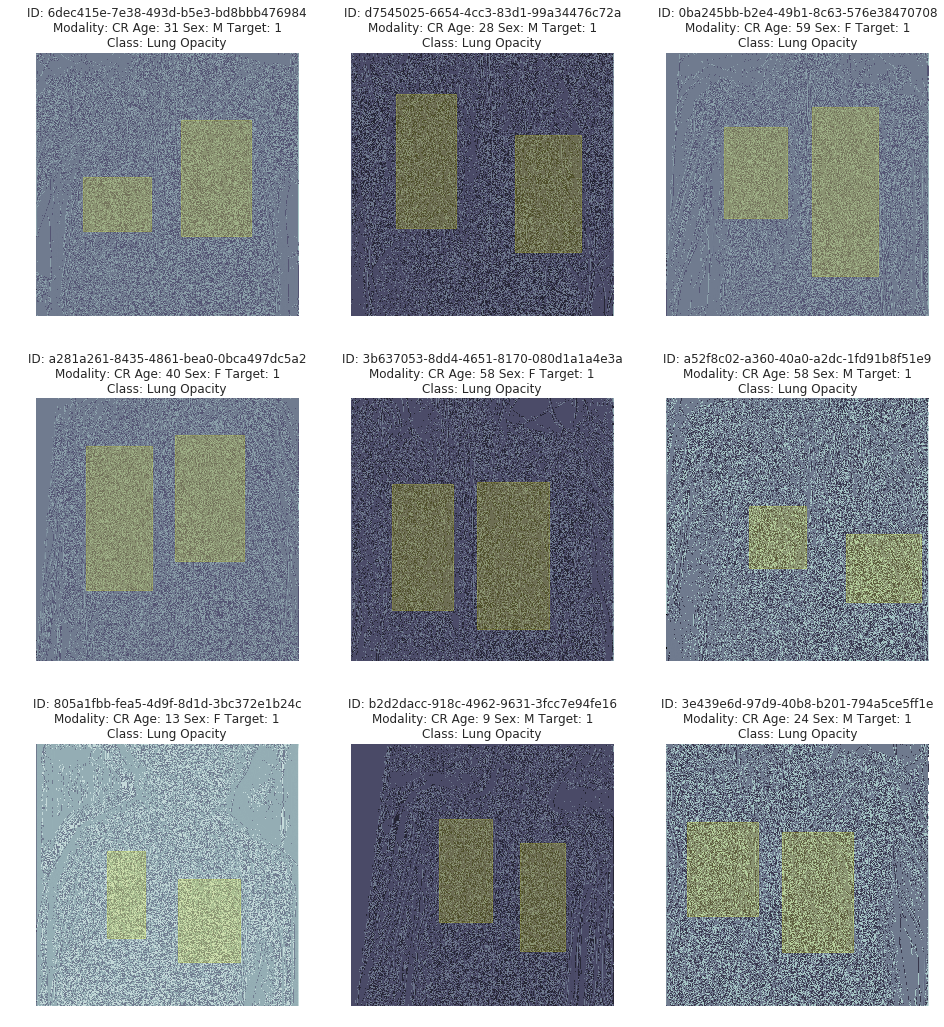

In [35]:
show_dicom_gradient_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

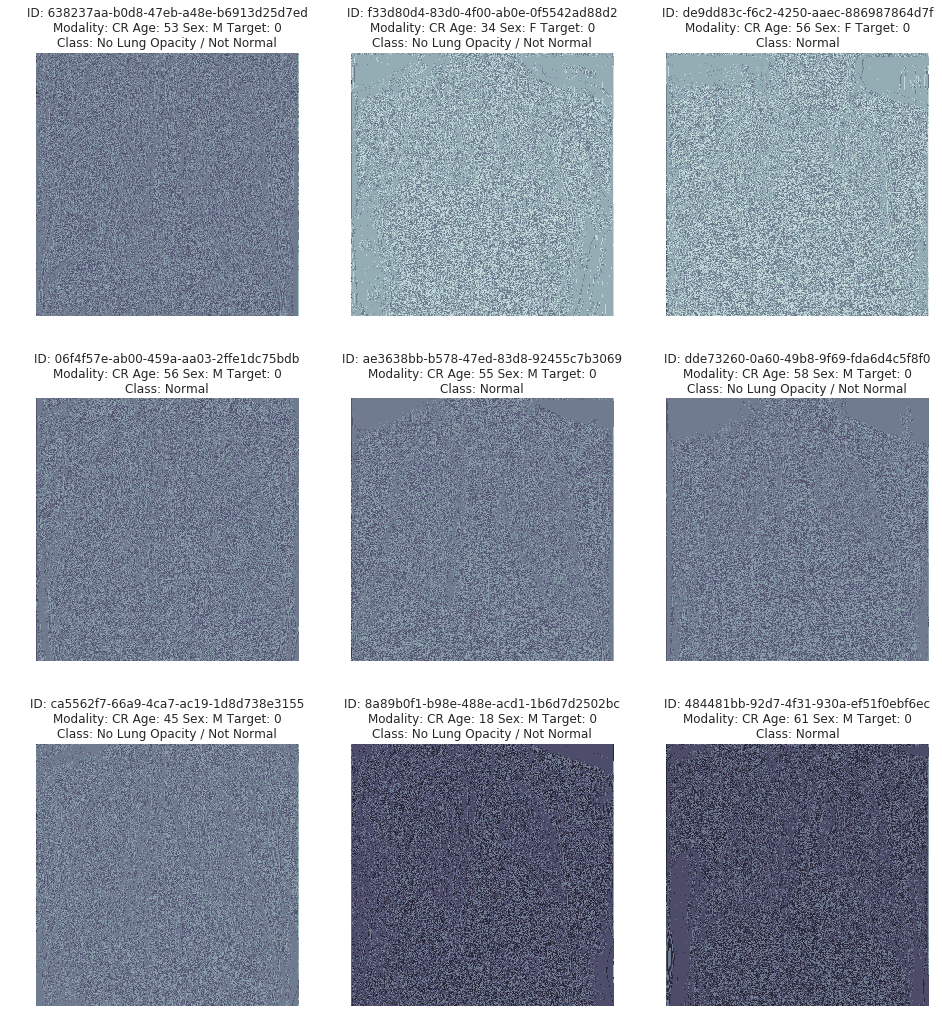

In [147]:
show_dicom_gradient_with_boxes(train_class_df[train_class_df['Target']==0].sample(9))

<a href="#0"><font size="1">Go to top</font></a>   


## <a id="34">Add meta information from DICOM data</a>


### Train data

We will parse the DICOM meta information and add it to the train dataset. We will do the same with the test data.

In [35]:
import time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [36]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(PATH+data_path)
    with timer("Process DICOM data"):
        for i, img_name in enumerate(image_names):
            imagePath = os.path.join(PATH,data_path,img_name)
            data_row_img_data = dcm.read_file(imagePath)
            idx = (data_df['patientId']==data_row_img_data.PatientID)
            data_df.loc[idx,'Modality'] = data_row_img_data.Modality
            data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
            data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
            data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
            data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
            data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
            data_df.loc[idx,'Rows'] = data_row_img_data.Rows
            data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
            data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [37]:
process_dicom_data(train_class_df,'stage_1_train_images/')

Process DICOM data - done in 815s


### Test data

We will create as well a test dataset with similar information.

In [38]:
test_class_df = pd.read_csv(PATH+'/stage_1_sample_submission.csv')

In [39]:
test_class_df = test_class_df.drop('PredictionString',1)
process_dicom_data(test_class_df,'stage_1_test_images/')

Process DICOM data - done in 23s


<a href="#0"><font size="1">Go to top</font></a>


## <a id="35">Modality</a>

Let's check how many modalities are used. Both train and test set are checked.

In [ ]:
print("Modalities: train:",train_class_df['Modality'].unique(), "test:", test_class_df['Modality'].unique())

The meaning of this modality is **CR** - **Computer Radiography**  <a href='#4'>[2]</a> <a href='#4'>[3]</a>.


## <a id="36">Body Part Examined</a>

Let's check if other body parts than 'CHEST' appears in the data.

In [ ]:
print("Body Part Examined: train:",train_class_df['BodyPartExamined'].unique(), "test:", test_class_df['BodyPartExamined'].unique())

## <a id="37">View Position</a>

View Position is a radiographic view associated with the Patient Position. Let's check if the View Positions.

In [ ]:
print("View Position: train:",train_class_df['ViewPosition'].unique(), "test:", test_class_df['ViewPosition'].unique())

Both **AP** and **PA** body positions are present in the data.  The meaning of these view positions are <a href='#4'>[2]</a> <a href='#4'>[3]</a>:
* **AP** - Anterior/Posterior;    
* **PA** - Posterior/Anterior.  

## <a id="38">Conversion Type</a>

Let's check the Conversion Type data.

In [ ]:
print("Conversion Type: train:",train_class_df['ConversionType'].unique(), "test:", test_class_df['ConversionType'].unique())

Both train and test have only **WSD** Conversion Type Data. The meaning of this Conversion Type is **WSD**: **Workstation**.

## <a id="39">Rows and Columns</a>

In [ ]:
print("Rows: train:",train_class_df['Rows'].unique(), "test:", test_class_df['Rows'].unique())
print("Columns: train:",train_class_df['Columns'].unique(), "test:", test_class_df['Columns'].unique())

Only {Rows:Columns} {1024:1024} are present in both train and test.  


<a href="#0"><font size="1">Go to top</font></a>

## <a id="310">Patient Age</a>

Let's examine now the data for the Patient Age for the train set.

### Train dataset

In [ ]:
tmp = train_class_df.groupby(['Target', 'PatientAge'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientAge']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

In [ ]:
tmp = train_class_df.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

In [ ]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='Target',data=df2)
plt.title("Train set: Chest exams Age and Target")
plt.xticks(rotation=90)
plt.show()

In [ ]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='class',data=df3)
plt.title("Train set: Chest exams Age and class")
plt.xticks(rotation=90)
plt.show()


**Note**: most probably, the values of age 148 to 155 are mistakes.   

Let's check also the distribution of patient age for the test data set.

### Test dataset



In [ ]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(test_class_df['PatientAge'], ax=ax)
plt.title("Test set: Patient Age")
plt.xticks(rotation=90)
plt.show()

<a href="#0"><font size="1">Go to top</font></a>


## <a id="311">Patient Sex</a>

Let's examine now the data for the Patient Sex.   

### Train dataset

We represent the number of Exams for each Patient Sex, grouped by value of Target.

In [ ]:
tmp = train_class_df.groupby(['Target', 'PatientSex'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientSex']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='Target',data=df2)
plt.title("Train set: Patient Sex and Target")
plt.show()

We represent the number of Exams for each Patient Sex, grouped by value of  class.

In [ ]:
tmp = train_class_df.groupby(['class', 'PatientSex'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientSex']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()

Let's check as well the distribution of Patient Sex for the test data.   

### Test dataset

In [ ]:
sns.countplot(test_class_df['PatientSex'])
plt.title("Test set: Patient Sex")
plt.show()

<a href="#0"><font size="1">Go to top</font></a>


# <a id='4'>Conclusions</a>   

After exploring the data, both the tabular and DICOM data, we were able to:  
- discover duplications in the tabular data;  
- explore the DICOM images;  
- extract meta information from the DICOM data;  
- add features to the tabular data from the meta information in DICOM data;  
- further analyze the distribution of the data with the newly added features from DICOM metadata;  

**Note**: this Kernel is still under development. Please give me your suggestions for improvement and as well, stay tuned, it is more to come.  



<a href="#0"><font size="1">Go to top</font></a>

# <a id='5'>References</a>  


[1] Kevin Mader, Lung Opacity Overview, https://www.kaggle.com/kmader/lung-opacity-overview  
[2] Modality Specific Modules, DICOM Standard,  http://dicom.nema.org/medical/dicom/2014c/output/chtml/part03/sect_C.8.html  
[3] DICOM Standard, https://www.dicomstandard.org/     




<a href="#0"><font size="1">Go to top</font></a>
